# Название проекта
Исследование поведения пользователей нашего мобильного приложения.

## Описание проекта
Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

## Цель проекта
Построить воронку продаж и изучить поведение пользователей. Исследовать резултаты А/А/В тест, прокомментировать результаты и выяснить, какой шрифт лучше.

# Предобработка данных

In [1]:
import math as mth
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
pd.options.mode.chained_assignment = None  # default='warn'
import warnings

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
data = pd.read_csv('logs_exp.csv', sep='\t')
pd.options.display.max_colwidth = 150
display(data.head(5))
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


У нас есть таблица logs_exp, где каждая запись в логе — это действие пользователя, или событие:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Пропусков в таблице нет. Посмотрим на дубликаты:

In [3]:
print(data.duplicated().sum())# подсчёт явных дубликатов

413


В этом проекте мы работаем с воронками, в воронках не важно сколько раз появлялось то или иное событие от пользователя, важно что оно появлялось хотя бы один раз. Поэтому дубликаты чистить не обязательно.


Заменим названия столбцов на более удобные.

In [4]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'eventname': 'event_name', 'deviceidhash': 'device_id_hash',
                   'eventtimestamp': 'event_timestamp', 'expid': 'exp_id'})  # переименование столбцов
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Поменяем тип данных в столбце с датами на datetime и добавим новый столбец с датой отдельно.

In [5]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = pd.to_datetime(data['event_timestamp']).dt.date
#data['event_date'] = pd.to_datetime(data['event_date'])

data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Выводы предобработки

Мы заменили названия столбцов на удобные, проверили пропуски и типы данных. Откорректировали и добавили столбец даты и времени, а также добавили отдельный столбец дат.

# Изучение и проверка данных

Посмотрим сколько всего событий в логе.

In [6]:
print('Всего различных событий в логе:', data['event_name'].nunique())
data_sob = data.groupby('event_name').agg({
    'device_id_hash': 'count'
}).sort_values(by= 'device_id_hash', ascending=False)
data_sob

Всего различных событий в логе: 5


,device_id_hash
event_name,
MainScreenAppear,119205
OffersScreenAppear,46825
CartScreenAppear,42731
PaymentScreenSuccessful,34313
Tutorial,1052


Посмотрим сколько всего пользователей в логе.

In [7]:
print('Всего пользователей в логе:', data['device_id_hash'].nunique())

Всего пользователей в логе: 7551


Посмотрим сколько в среднем событий приходится на пользователя.

In [8]:
data_pivot = data.pivot_table(values='event_name',
                              index='device_id_hash', aggfunc='count')
data_pivot.describe()

,event_name
count,"7,551.00"
mean,32.33
std,65.31
min,1.00
25%,9.00
50%,20.00
75%,37.50
max,"2,308.00"


В среденем на пользователя приходится 32 события. Минимально одно событие на пользователя, а медианное значение 20 событий. Посмотрим, данными за какой период мы располагаем.

In [9]:
print('Начало периода', data['event_date'].min())
print('Конец периода', data['event_date'].max())

Начало периода 2019-07-25
Конец периода 2019-08-07


То есть у нас есть данные за две недели. Построим гистограмму по дате и времени.

(Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Число событий'),
 Text(0.5, 1.0, 'Распределений событий по времени'))

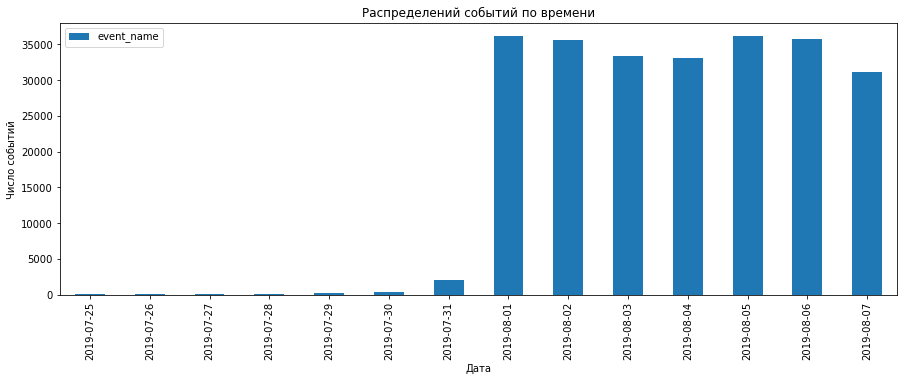

In [10]:
data.groupby('event_date').agg({'event_name': 'count'}).plot(kind='bar', figsize=(15,5))
plt.xlabel('Дата'), plt.ylabel('Число событий'), plt.title('Распределений событий по времени')

Можно увидеть, что у нас данные только за одну неделю с первого августа. Поэтому возьмем срез данных только за вторую неделю из двух. Такое возможно, так как технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Откуда берутся события из прошлого - события обычно шлются в систему с клиентских устройств (с мобильных телефонов, например). Иногда, когда устройство не в сети, оно может накапливать события и слать позже при входе в сеть. При этом момент времени, когда событие случилось и когда оно принято сервером могут сильно различаться. Для любого события хранятся, как правило, два поля с датой-временем - время отправки и время приема. В нашей задаче, скорее всего, данные выгрузили по времени приема, а не по времени отправки, но в датасете оставили только время отправки.

In [11]:
data['event_date'] = pd.to_datetime(data['event_date'])
data_new = data.query('event_date >= "2019-08-01"')
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241298 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       241298 non-null  object        
 1   device_id_hash   241298 non-null  int64         
 2   event_timestamp  241298 non-null  datetime64[ns]
 3   exp_id           241298 non-null  int64         
 4   event_date       241298 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


Посмотрим, сколько строк потеряли при срезе:

In [12]:
print('Потеряли строк:', len(data['event_date']) - len(data_new['event_date']))
print('Потеряли долю от всех:', (len(data['event_date']) - len(data_new['event_date']))/len(data['event_date']))
data_new_sob = data_new.groupby('event_name').agg({
    'device_id_hash': 'count'
}).sort_values(by= 'device_id_hash', ascending=False)
data_new_sob['% потерь'] = (data_sob['device_id_hash'] - data_new_sob['device_id_hash'])\
/data_sob['device_id_hash']
data_new_sob

Потеряли строк: 2828
Потеряли долю от всех: 0.011584181938834865


,device_id_hash,% потерь
event_name,,
MainScreenAppear,117431,0.01
OffersScreenAppear,46350,0.01
CartScreenAppear,42365,0.01
PaymentScreenSuccessful,34113,0.01
Tutorial,1039,0.01


В целом мы потеряли только один процент данных при срезе и по каждому событию тоже без перекосов, везде по одному проценту. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [13]:
data_new.groupby('exp_id').agg({
    'device_id_hash': 'count'
}).sort_values(by= 'device_id_hash', ascending=False)

,device_id_hash
exp_id,
248,84726
246,79425
247,77147


Таким образом, у нас есть пользователи из всех трех экспериментальных групп.

## Выводы изучения и проверки данных

Мы посмотрели, данными за какой период мы располагаем(2 недели). Нашли максимальную и минимальную дату и построили гистограмму по дате и времени. Определили, с какого момента данные полные и отбросили более старые. Оказалось, что на самом деле мы располагаем данными за одну неделю, а также проверили, что у нас есть пользователи из всех трёх экспериментальных групп. Приступим к изучению воронки событий.

# Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются, отсортируем события по частоте и посчитаем, сколько пользователей совершали каждое из этих событий. Потом отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие.

In [14]:
voronka = data_new.groupby('event_name').agg({
    'event_date': 'count',
    'device_id_hash': 'nunique'
}).sort_values(by='device_id_hash', ascending=False)
voronka['% уникальных от всех уникальных'] = voronka['device_id_hash']/data_new['device_id_hash'].nunique()
voronka = voronka.rename(columns={'event_date': 'кол-во', 'device_id_hash': 'уникальные'})
voronka

,кол-во,уникальные,% уникальных от всех уникальных
event_name,,,
MainScreenAppear,117431,7419,0.98
OffersScreenAppear,46350,4593,0.61
CartScreenAppear,42365,3734,0.50
PaymentScreenSuccessful,34113,3539,0.47
Tutorial,1039,840,0.11


Судя про тому, что даже на первом этапе не 100%, то пользователь не обязан пройти по всем этапам для того, чтобы купить товар, то есть этапы воронки не являются обязательными. Возможно он может по прямой ссылке попадать сразу к товару и т.д. Можно сделать предположение, что события выстраиваются в последовательности MainScreenAppear(главный экран) → OffersScreenAppear(появление предложений) → CartScreenAppear(корзина) → PaymentScreenSuccessful(успешный платеж). Туториал - это обучалка в приложении. Обычно ее показывают самым новым пользователям. Думаю, что это событие не имеет отношения к воронке покупок, поэтому можно его исключить из нашей воронки.

In [15]:
voronka = voronka.query('event_name != "Tutorial"')
voronka

,кол-во,уникальные,% уникальных от всех уникальных
event_name,,,
MainScreenAppear,117431,7419,0.98
OffersScreenAppear,46350,4593,0.61
CartScreenAppear,42365,3734,0.50
PaymentScreenSuccessful,34113,3539,0.47


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
Посмотрим на каком шаге теряем больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.

In [16]:
voronka['conv'] = voronka['уникальные']/voronka['уникальные'].values[0]
voronka['prev_step'] = voronka['уникальные'].shift()
voronka['step_conv'] = voronka['уникальные']/voronka['prev_step']#конверсия в следующий шаг
voronka

,кол-во,уникальные,% уникальных от всех уникальных,conv,prev_step,step_conv
event_name,,,,,,
MainScreenAppear,117431,7419,0.98,1.00,NaN,NaN
OffersScreenAppear,46350,4593,0.61,0.62,"7,419.00",0.62
CartScreenAppear,42365,3734,0.50,0.50,"4,593.00",0.81
PaymentScreenSuccessful,34113,3539,0.47,0.48,"3,734.00",0.95


На мой взгляд относительные воронки - это зло. Потому, что в них неуклонно снижается на каждом шаге число наблюдений и, следовательно, адекватность оценки % прохождения на следующий шаг. Поэтому я построил конверсию в шаг. По ней видно, что больше всего не переходящих дальше пользователей с первого на второй шаг(MainScreenAppear(главный экран) → OffersScreenAppear(появление предложений)). По абсолютной воронке видно, что почти половина пользователей доходит от первого события до оплаты.

## Выводы изучения воронки событий

Мы посмотрели, какие события есть в логах, как часто они встречаются, отсортировали события по частоте. Посчитали, сколько пользователей совершали каждое из этих событий, отсортировали события по числу пользователей и посчитали долю пользователей, которые хоть раз совершали событие. Предположили, в каком порядке происходят события. Решили убрать "туториал" из воронки.
По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
Определили, на каком шаге теряли больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.

#  Изучение результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе и проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешного A/A-теста:
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Таким образом, сформулируем гипотезы Н0: Нет статистически значимых различий в доле пользователей, совершивших событие Х.
H1: Есть статистически значимые различия в доле пользователей, совершивших событие Х
Проверим, встречаются ли пользователи в разных контрольных группах.

In [18]:
data_246 = data_new.query('exp_id == 246')
data_247 = data_new.query('exp_id == 247')
data_248 = data_new.query('exp_id == 248')
# проверка на пересечение пользователей
print('Пересечение пользователей в группах 246 и 247:', len(np.intersect1d(
    data_246['device_id_hash'].unique(), data_247['device_id_hash'].unique())))
print('Пересечение пользователей в группах 248 и 247:', len(np.intersect1d(
    data_248['device_id_hash'].unique(), data_247['device_id_hash'].unique())))
print('Пересечение пользователей в группах 246 и 248:', len(np.intersect1d(
    data_246['device_id_hash'].unique(), data_248['device_id_hash'].unique())))

Пересечение пользователей в группах 246 и 247: 0
Пересечение пользователей в группах 248 и 247: 0
Пересечение пользователей в группах 246 и 248: 0


In [19]:
trials = data_new.groupby('exp_id').agg({'device_id_hash': 'nunique'})
display(trials)
funnel = data_new.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
funnel

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Посмотрев на группы можно сказать, что размеры групп таковы, что количественно между группами отличие около одного процента. Рзличия между группами минимальны.

In [20]:
def check_hypothesis(successes1, successes2, trials1, trials2):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1+successes2)/(trials1+trials2)
    difference = p1-p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / \
        mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value


alpha = 0.01
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 247],
                        trials.loc[246].values[0], trials.loc[247].values[0]) < alpha:
        result = 'значимо'
    else:
        result = 'незначимо'
    print(f'Отличие между группами 246 и 247 по событию {event} статистически {result}, p_value = ',
          check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 247],
                           trials.loc[246].values[0], trials.loc[247].values[0]))

Отличие между группами 246 и 247 по событию MainScreenAppear статистически незначимо, p_value =  0.7570597232046099
Отличие между группами 246 и 247 по событию OffersScreenAppear статистически незначимо, p_value =  0.2480954578522181
Отличие между группами 246 и 247 по событию CartScreenAppear статистически незначимо, p_value =  0.22883372237997213
Отличие между группами 246 и 247 по событию PaymentScreenSuccessful статистически незначимо, p_value =  0.11456679313141849


Здесь использовали критерий значимости = 0,01, так как А/А тест применяют там, где степень различия между группами не больше 10%. В таких случаях точность A/A-теста в 1% — распространённый критерий. Таким образом, после проведения А/А теста можно видеть, что нет статистически значимых различий в доле пользователей, совершивших все события в нашей воронке. Теперь посмотрим на результаты сравнения 246 и 248 группы.

В этом тесте и в следующих использоваю альфа = 0.00427(поправка Шидака), так как тестов у нас будет 3 по 4(А/В, А/В и А+А/В). А теперь посмотрим разницу между группами 247 и 248

In [21]:
alpha = 0.017
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 248],
                        trials.loc[246].values[0], trials.loc[248].values[0]) < alpha:
        result = 'значимо'
    else:
        result = 'незначимо'
    print(f'Отличие между группами 246 и 248 по событию {event} статистически {result}, p_value = ',
          check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 248],
                           trials.loc[246].values[0], trials.loc[248].values[0]))

Отличие между группами 246 и 248 по событию MainScreenAppear статистически незначимо, p_value =  0.2949721933554552
Отличие между группами 246 и 248 по событию OffersScreenAppear статистически незначимо, p_value =  0.20836205402738917
Отличие между группами 246 и 248 по событию CartScreenAppear статистически незначимо, p_value =  0.07842923237520116
Отличие между группами 246 и 248 по событию PaymentScreenSuccessful статистически незначимо, p_value =  0.2122553275697796


In [22]:
alpha = 0.017
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 247], funnel.loc[event, 248],
                        trials.loc[247].values[0], trials.loc[248].values[0]) < alpha:
        result = 'значимо'
    else:
        result = 'незначимо'
    print(f'Отличие между группами 247 и 248 по событию {event} статистически {result}, p_value = ',
          check_hypothesis(funnel.loc[event, 247], funnel.loc[event, 248],
                           trials.loc[247].values[0], trials.loc[248].values[0]))

Отличие между группами 247 и 248 по событию MainScreenAppear статистически незначимо, p_value =  0.4587053616621515
Отличие между группами 247 и 248 по событию OffersScreenAppear статистически незначимо, p_value =  0.9197817830592261
Отличие между группами 247 и 248 по событию CartScreenAppear статистически незначимо, p_value =  0.5786197879539783
Отличие между группами 247 и 248 по событию PaymentScreenSuccessful статистически незначимо, p_value =  0.7373415053803964


После проведения А/В(группы 246 и 248, группы 247 и 248) теста можно видеть, что нет статистически значимых различий в доле пользователей, совершивших все события в нашей воронке. Теперь сравним результаты с объединённой контрольной группой. Сначала объединим группы и назовем их группу 0.

In [23]:
data_new.loc[(data_new.exp_id < 248), ('exp_id')] = 0
trials0 = data_new.groupby('exp_id').agg({'device_id_hash': 'nunique'})
display(trials0)
funnel0 = data_new.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
funnel0

,device_id_hash
exp_id,
0,4997
248,2537


exp_id,0,248
event_name,,
CartScreenAppear,2504,1230
MainScreenAppear,4926,2493
OffersScreenAppear,3062,1531
PaymentScreenSuccessful,2358,1181
Tutorial,561,279


Единственное, теперь группы перекошены... Но все равно проверим.

In [24]:
alpha = 0.017
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel0.loc[event,0], funnel.loc[event, 248],
                        trials0.loc[0].values[0], trials.loc[248].values[0]) < alpha:
        result = 'значимо'
    else:
        result = 'незначимо'
    print(f'Отличие между группами 0 и 248 по событию {event} статистически {result}, p_value = ',
          check_hypothesis(funnel0.loc[event, 0], funnel.loc[event, 248],
                           trials0.loc[0].values[0], trials.loc[248].values[0]))

Отличие между группами 0 и 248 по событию MainScreenAppear статистически незначимо, p_value =  0.29424526837179577
Отличие между группами 0 и 248 по событию OffersScreenAppear статистически незначимо, p_value =  0.43425549655188256
Отличие между группами 0 и 248 по событию CartScreenAppear статистически незначимо, p_value =  0.18175875284404386
Отличие между группами 0 и 248 по событию PaymentScreenSuccessful статистически незначимо, p_value =  0.6004294282308704


Здесь мы тоже видим, что нет статистически значимых различий в доле пользователей, совершивших все события в нашей воронке. А значит, шрифт можно менять, а можно оставить, на продажах это не сказывается.

## Выводы изучения эксперимента

Мы проделали 16 тестов и приняли в них поправку Шидака. Ни в одном из проделанных тестов отличие между группами не было статистически значимо. Это значит, что мы не отвергли нулевую гипотезу, следовательно, и разницу между новым и старым шрифтом стат-тест не заметил.

# Вывод

Мы проделали большую работу:
- Сначала предобработали данные: заменили названия столбцов на удобные, проверили пропуски и типы данных, откорректировали и добавили столбец даты и времени, а также добавили отдельный столбец дат. 
- Дальше проверили, данными за какой период мы располагаем(2 недели). Нашли максимальную и минимальную дату и построили гистограмму по дате и времени.
- Определили, с какого момента данные полные и отбросили более старые. Оказалось, что на самом деле мы располагаем данными за одну неделю, а также проверили, что у нас есть пользователи из всех трёх экспериментальных групп.
- Посмотрели, какие события есть в логах, как часто они встречаются, отсортировали события по частоте. Посчитали, сколько пользователей совершали каждое из этих событий, отсортировали события по числу пользователей и посчитали долю пользователей, которые хоть раз совершали событие. Предположили, в каком порядке происходят события и решили убрать "туториал" из воронки.
- По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Определили, на каком шаге теряли больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.
- И наконец проделали 16 статистических тестов, по итогам которых мы не отвергли нулевую гипотезу, следовательно, и разницу между новым и старым шрифтом стат-тест не заметил.